Case 3
Fabian Brock
i6248959

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# filter warnings ignore
import warnings
warnings.filterwarnings('ignore')

Consider the unit-linked contract with maturity guarantee that was discussed in Week 1.
Take the risk-free rate equal to r = 1%, the volatility of the investment fund sigma = 15% and
the final guaranteed amount at T = 10 equal to 100 (i.e., we have a contract with a 0%
guarantee).
Consider the binomial tree from Case 1. The standard way of interpreting the binomial
pricing formula $f_{t-\delta t} = \frac{1}{R_{\delta t}} (p_{\delta t }f_{t, u} + (1-p_{\delta t }) f_{t, d})$ is as a “discounted risk-neutral
expectation”. We now want to change the interpretation to computing the expectation of a
martingale of prices divided by a numéraire asset. Check the slides from week 1, and Joshi
Section 6.5 on discrete martingales.

Questions Binomial Tree
• Use the money-market account $B_t$ as a numéraire. Rewrite your binomial tree
program to compute the expectation of a martingale in each binomial step (no
discounting allowed!). This requires that you divide the final payoff by the numéraire
and compute in every node in the binomial tree the relative price w.r.t the
numéraire. At time $t=0$, you must convert this relative price back to € by
multiplying with the numéraire. Check that your price is correct.
• Use the stock-price $S_t$ as a numéraire and do the martingale calculation in the
binomial tree (rewrite your code once more). Check that your price is still correct.
• Would it be possible to use the unit-linked contract itself as a numéraire?
• Would it be possible to use a call-option (payoff $max\{S_t − K, 0\}$) as a numéraire?
• Would it be possible to use cash (a constant process $C_t≡ 1$) as a numéraire?

In [14]:
def price_contract_vectorized_bank(r,sigma,T,guarantee, n, initial_price=100):
    dt = T/n
    R = np.exp(r*dt)
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    p = (R-d)/(u-d)

    numeraire = np.exp(r*dt)
    #ft = ((p * u/R) * (ft+1u/St+1u) + (p * d/R)* (ft+1d/St+1d)) * St
    # S is the numeraire

    # money market account as numeraire that grows at risk free rate r
    # init money market account (joshi 6.45)
    S = 1 * np.exp(r*dt) ** np.arange(0,n+1,1)
    S1u = S[0] * u
    S1d = S[0] * d
    pstar = (S[0] - S1d/numeraire) / (S1u/numeraire - S1d/numeraire)

    # init asset prices at maturity
    stock = initial_price * u ** np.arange(0,n+1,1) * d ** np.arange(n,-1,-1)

    # init option prices at maturity
    stock = np.maximum(guarantee-stock, np.zeros(n+1))
    # calculate option prices at each node
    for i in np.arange(n,0,-1):
        # remove the discounting and use pstar
        stock = (pstar * stock[1:i+1] + (1-pstar) * stock[0:i])

        #div by numeraire
        stock /= numeraire

    # multiply by numeraire
    return stock[0] * S[0]

In [15]:
def price_contract_vectorized_stock(r,sigma,T,guarantee, n, initial_price=100):
    dt = T/n
    R = np.exp(r*dt)
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    numeraire = np.exp(r*dt)

    pstar1 = ((R-d)*R) / ((u-d)*R)
    pstar2 = ((u-R)*R) / ((u-d)*R)


    # init asset prices at maturity
    stock = initial_price * u ** np.arange(0,n+1,1) * d ** np.arange(n,-1,-1)

    # init option prices at maturity
    stock = np.maximum(guarantee-stock, np.zeros(n+1))
    # calculate option prices at each node
    for i in np.arange(n,0,-1):
        # remove the discounting and use pstar
        stock = (pstar1 * stock[1:i+1] + pstar2 * stock[0:i])

        #div by numeraire
        stock /= numeraire

    # multiply by numeraire
    return stock[0]

In [16]:
r = 0.01
sigma = 0.15
T = 10
guarantee = 100
n = 100 # number of steps

# plot price
print("Price with bank account as numeraire: {}".format(price_contract_vectorized_bank(r,sigma,T,guarantee,n)))
print("Price with bank account as numeraire: {}".format(price_contract_vectorized_stock(r,sigma,T,guarantee,n)))
print("Prices look correct")

Price with bank account as numeraire: 13.439537823428756
Price with bank account as numeraire: 13.439537823428855
Prices look correct


# Binomial Tree Questions
Using the Unit linked contract as numeraire itself does not really make sense since you would be expressing units of UL contracts in terms of UL contracts. It would probably still be possible since traded, and strictly positive price.
A call option can be used since it is traded and strictly positive price.
Cash can't be used since it is not considered a traded asset (I think we talked about this in class) also it constantly depreciates in value and creates arbitrage opportunities.

Questions Monte Carlo
• Write a computer program to compute the price of a UL contract with a Monte Carlo
simulation.
• Investigate the convergence behaviour for increasing number of paths 𝑀𝑀. (Confirm the $O(M^{-1/2})$ convergence rate.)
• Re-run your MC calculation multiple times for $M=1000$ (using different seed-values for the
random number generator!). Plot the empirical distribution function of the estimator $\hat{E}$.
Compare this distribution to the asymptotic approximation $\hat{E} ≈ n(E[f], Var[f]/M)$.
• If you generate M paths with N time-steps, then you need MN random numbers in total.
Suppose you have a fixed budget of $10^6$ random numbers. Is it better to choose a large M
(with smaller N) or choose a large N (with smaller M) to obtain the most accurate MC
estimate for a fixed “budget” $MN ≤ 10^6$?


In [17]:
# create a method for the monte carlo pricing
def MC_price(S0, r, sigma, T, K, M, n):
    dt = T/n # timesteps
    # geometric brownian motion
    St = np.exp(
        (r - sigma ** 2 / 2) * dt
        + sigma * np.random.normal(0, np.sqrt(dt), size=(M,n)).T
    )

    # include array of 1's
    St = np.vstack([np.ones(M), St])

    # multiply through by S0 and get cumprod of elements along sim path
    St = S0 * St.cumprod(axis=0)

    # payoff funciton
    def payoff(S, K):
        return np.maximum(S[-1], K)

    # discounting
    def discounting(r, t):
        return np.exp(-r*t)

    # get the payoff of each path and take mean
    payoff = payoff(St, K)
    discounting = discounting(r, T)
    price = np.mean(payoff * discounting)
    # get std of payoff
    std = np.std(payoff * discounting)

    return np.round(price, 3), np.round(std, 3)

In [18]:
r = 0.01
sigma = 0.15
T = 10
S0 = 100
K = 100

# sim params
M = 100 # numer of paths
n = 100 # number of time steps
MC_price(S0, r, sigma, T, K, M, n)

(114.829, 41.377)

In [19]:
# convergence behaviour for increasing M
Ms = np.arange(100, 10000, 1000)
prices = []
stds = []
n = 50
iters = 1000 # run the MC simulation 100 times for each M and take average
for M in Ms:
    price = 0
    std = 0
    for i in range(iters):
        p, s = MC_price(S0, r, sigma, T, K, M, n)
        price += p
        std += s
    prices.append(price/iters)
    stds.append(std/iters)



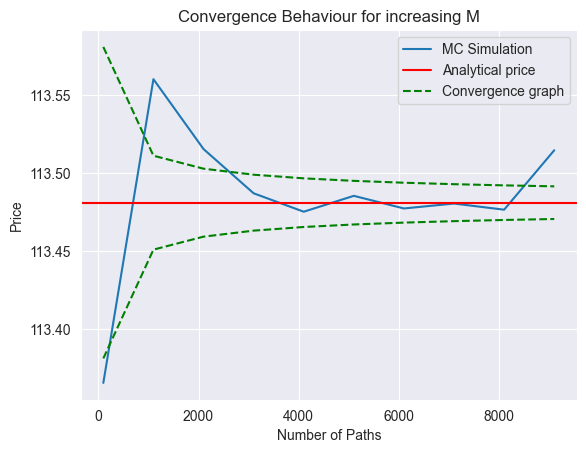

In [20]:
# plot the prices and the std above and below the price with respect to Ms
plt.plot(Ms, prices, label="MC Simulation")
#plt.plot(Ms, np.array(prices) + np.array(stds)) , std convergence may also be interesting, but hard to see price convergence
# analytical price of 113.481
plt.axhline(y=113.481, color='r', linestyle='-', label="Analytical price")
# also plot the convergence graph of 1/sqrt(M) + analytical price (and flipped)
plt.plot(Ms, 1/np.sqrt(Ms) + 113.481, color='g', linestyle='--', label="Convergence graph")
plt.plot(Ms, -1/np.sqrt(Ms) + 113.481, color='g',linestyle='--')
plt.xlabel("Number of Paths")
plt.ylabel("Price")
plt.legend()
plt.title("Convergence Behaviour for increasing M")
plt.show()


Clearly the MC simulation exhibits similar convergence behaviour as the 1/sqrt(M) function.

In [21]:
# Re-run your MC calculation multiple times for  𝑀=1000

M = 1000
n = 1000
iters = 1000
prices = []
for i in range(iters):
    p, s = MC_price(S0, r, sigma, T, K, M, n)
    prices.append(p)


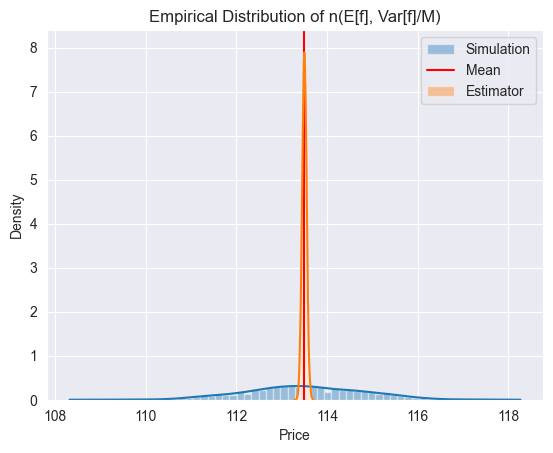

In [22]:
sb.distplot(prices, bins=50, label="Simulation")
plt.axvline(x=np.mean(prices), color='r', linestyle='-', label="Mean")
# plot normal with mean 113.481 and std (var(prices)/M))
# generate 1000 values from the normal distribution
norm = np.random.normal(np.mean(prices), np.var(prices)/np.sqrt(M), 10000)
sb.distplot(norm, label="Estimator", bins=50)
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Empirical Distribution of n(E[f], Var[f]/M)")
plt.legend()
plt.show()

I feel like I did something wrong here maybe? So I tried it out for n(E[f], Var[f]) instead of n(E[f], Var[f]/M) and it looks much better.

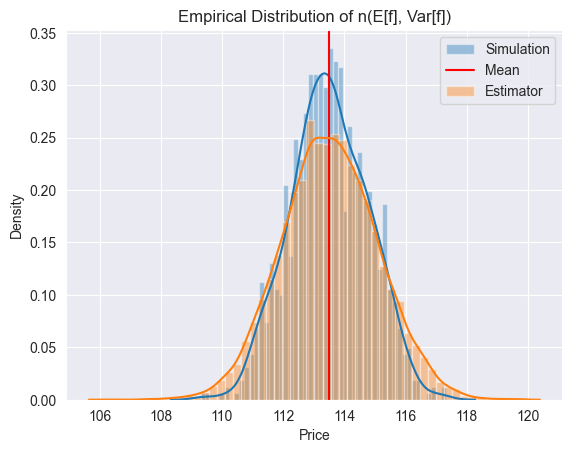

In [23]:
sb.distplot(prices, bins=50, label="Simulation")
plt.axvline(x=np.mean(prices), color='r', linestyle='-', label="Mean")
norm = np.random.normal(np.mean(prices), np.var(prices), 10000)
sb.distplot(norm, label="Estimator", bins=50)
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Empirical Distribution of n(E[f], Var[f])")
plt.legend()
plt.show()

In [24]:
# we have MN random numbers in total, set limit of 10^6 = 1_000_000
# create a few combinations of M and N that satisfy MN <= 1_000_000
# and plot the convergence behaviour
Ms = np.array([10, 100, 1000, 10000, 100000])
Ns = 1_000_000 // Ms

def zipcalc(Ms, Ns, iters):
    prices = []
    stds = []
    for M, N in zip(Ms, Ns):
        price = 0
        std = 0
        for i in range(iters):
            p, s = MC_price(S0, r, sigma, T, K, M, N)
            price += p
            std += s
        prices.append(price/iters)
        stds.append(std/iters)
    return prices, stds

prices, stds = zipcalc(Ms, Ns, 50)

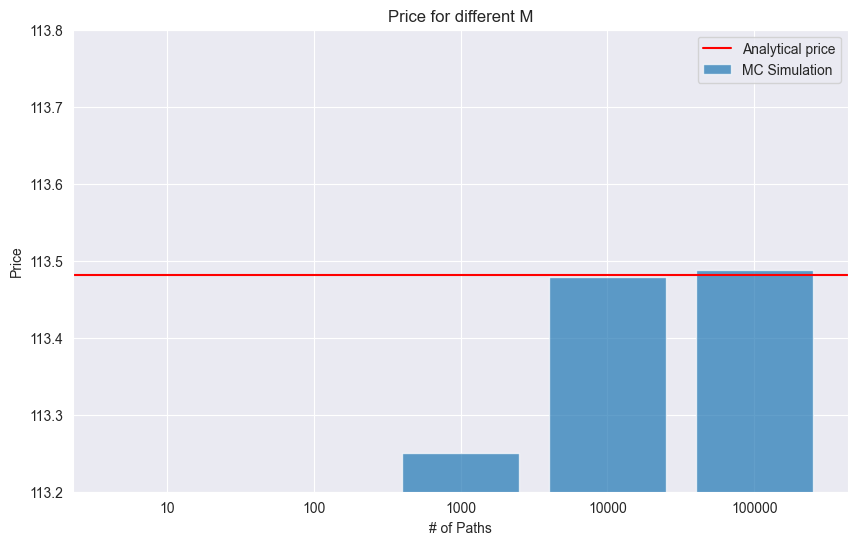

In [25]:
plt.figure(figsize=(10, 6))
bar_positions = range(len(Ms))  # fixed positions
plt.bar(bar_positions, prices, align='center', alpha=0.7, label='MC Simulation')

plt.axhline(y=113.481, color='r', linestyle='-', label='Analytical price')
plt.ylim(113.2, 113.8)

plt.xticks(bar_positions, Ms)

plt.xlabel('# of Paths')
plt.ylabel('Price')
plt.title('Price for different M')
plt.legend()
plt.show()


In [26]:
# swap M and N
Ms, Ns = Ns, Ms
prices, stds = zipcalc(Ms, Ns, 50)

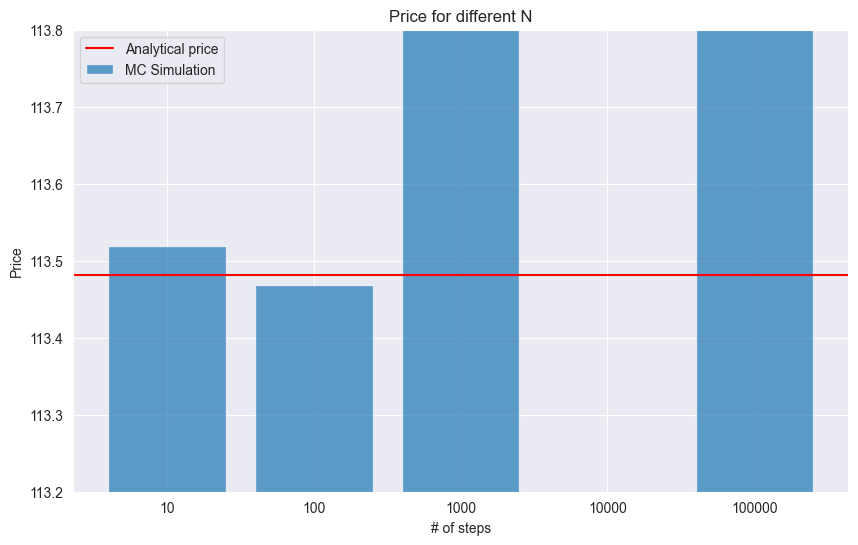

In [27]:
plt.figure(figsize=(10, 6))
bar_positions = range(len(Ns))  # Fixed positions for the bars
plt.bar(bar_positions, prices, align='center', alpha=0.7, label='MC Simulation')
plt.axhline(y=113.481, color='r', linestyle='-', label='Analytical price')
plt.ylim(113.2, 113.8)
plt.xticks(bar_positions, Ns)
plt.xlabel('# of steps')
plt.ylabel('Price')
plt.title('Price for different N')
plt.legend()
plt.show()

# Higher M is better than N
The Graphs clearly show that it is better to have higher M than N, i.e. more paths than time steps. This is actually quite unintuitive I feel like, since e.g. when trying to maximize the area of a square one would try to pick both values to be the most central ($1*9 = 9$ but $5*5=25$). Optimal values in this case seem to lie around M = 100,000 and N = 10. For the sake of time I did not investigate the surrounding values, but looking at the graphs, it seems that solution quality decreases quite significantly when using M = 10,000 and N = 100
